# `nnsim.jl` Tour
This notebook serves as a tutorial or tour of sorts of `nnsim`, a Julia package intended for forward simulation of neural networks (NNs). 

`nnsim` provides the general structure of a neural network topology from neurons to layers and full networks. The dynamics of neurons are specified by the user in the form of update mathematical update rules. Given a mathematical description of the neuron, `nnsim` then stacks these neurons into layers and networks which can be used for simulation or inference. 

In principle, both artificial and spiking NNs are supported. 

In [2]:
using Revise # Used for development
using Parameters
using nnsim
using PyPlot

## Neurons
The fundamental building block of a NN is the neuron. `nnsim` includes an `AbstractNeuron` type to be implemented by the user for their specified type. The full implementation of an _Izhikevich_ neuron is contained in the cell below.

For now, the only functions necessary for implementing a neural network are:
1. `update!` which implements the update rule for the neuron, including a concept of time
2. `reset!` which resets the neuron to its default state

It is important that any state variables in the type be stored within an `Array` under the name `state`, or otherwise the struct must be declared mutable. Code for tracking the internal states of the neurons requires the state(s) to be tracked be stored in a parameter named `state`.

In [3]:
@with_kw struct Izh{F}<:AbstractNeuron
   a::F = 0.02      # a-d are model parameters
   b::F = 0.2
   c::F = -65.
   d::F = 8.
   I::F = 25.       # Background current injection (mA)
   θ::F = 30.       # Threshold potential (mV)

   v0::F = -65.     # Reset voltage (mV)
   u0::F = 0.       # Reset state variable
   state::Array{F,1} = [-65., 0.]      # Membrane potential (mV) and state variable
end

Izh

In [4]:
function nnsim.update!(neuron::Izh, input_update, dt, t)
    retval = 0
    # If an impulse came in, add it
    neuron.state[1] += input_update
    
    # Euler update to the neuron state
    neuron.state[1] += dt*(0.04 * neuron.state[1]^2 + 5*neuron.state[1] + 140 - neuron.state[2] + neuron.I)
    neuron.state[2] += dt*(neuron.a)*(neuron.b*neuron.state[1]-neuron.state[2])
    
    # Check for thresholding
    if neuron.state[1] >= neuron.θ
        neuron.state[1] = neuron.v0
        neuron.state[2] = neuron.state[2] + neuron.d
        retval = 1
    end

    return retval
end

function nnsim.reset!(neuron::Izh)
    neuron.state .= [neuron.v0, neuron.u0]
end

### Neuron Simulation
The function below simulates a given neuron with no input (free evolution) for a duration `tsim` starting from `t=0` in increments of `dt`.

In practice, we rarely need to `update!` neurons directly. Rather, we will see soon that we have abstractions which manage the updates for invidual neurons (called `Layer`s, which are then handled by `Network`s). However, at a fundamental level, all that a `Layer` is doing is orchestrating the mass of calls to `update!` for neurons.

To demonstrate that the neuron is simulated correctly, we then plot the membrane potential and the recovery variable for the short simulation.

In [5]:
function simulate_neuron(neuron, dt, tsim)
    t = 0.
    neur_states = zeros(size(neuron.state)..., 0) # Matrix we'll store the simulation results in
    for j in 1:(tsim/dt)
        neur_states = hcat(neur_states, neuron.state) # Extend the neuron_state matrix with this iteration
        update!(neuron, 0, dt, t) # update the neuron
        t += dt
    end
    neur_states = hcat(neur_states, neuron.state)
    return neur_states
end;

In [6]:
# Unspecified fields get their default value. This is what the @with_kw macro gives us:
# specify some fields by name (a = ..., b = ..., c = ...) while the unspecified ones are left to their defaults
iz_neuron = Izh(a = 0.03, d = 9., θ = 33.); 
dt = 0.001
tsim = 60.

results = simulate_neuron(iz_neuron, dt, tsim);

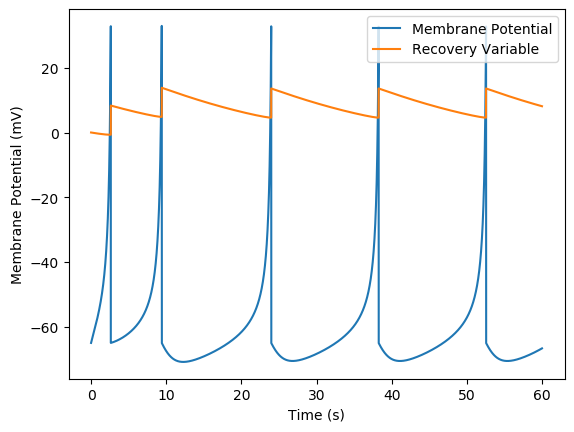

PyObject <matplotlib.legend.Legend object at 0x7f03e490a110>

In [7]:
plt.figure()
plt.plot(collect(1:length(results[1,:]))*dt, results')
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (mV)")
plt.legend(["Membrane Potential", "Recovery Variable"])

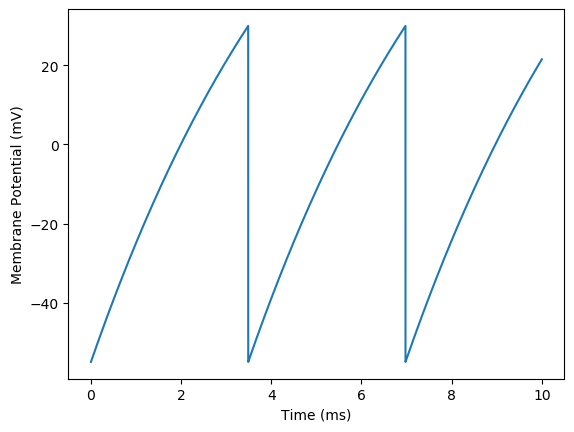

PyObject Text(24.00000000000002, 0.5, 'Membrane Potential (mV)')

In [8]:
lif_neuron = nnsim.LIF(R = 7., τ = 5.5, I = 18.) # We have LIF neurons implemented in the source, neurons.jl
dt = 0.001
tsim = 10.

results = simulate_neuron(lif_neuron, dt, tsim);

plt.figure()
plt.plot(collect(1:length(results[1,:]))*dt, results')
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")

## Layers
We're now ready to build layers and a full network out of these neurons!

A layer is a collection of neurons with input weights. For this reason, we need to specify both the input weights as well as the neurons that make up our layer. 

Let's construct two layers of eight homogeneous Izhikevich neurons each, all with the default parameters. 

In [9]:
N = 4

W1 = randn(N,2) .+ 4 # Random NxN matrix with normally distributed
W1 = W1./maximum(abs.(W1)) # Normalize
N1 = [Izh(a = 0.03, d = 9., θ = 33.) for _ in 1:N]
L1 = Layer(N1, W1); # Constructs a layer out of neurons in N1 and incoming weights W1

W2 = randn(N,N) .+ 4 
W2 = W2./maximum(abs.(W2)) 
N2 = [Izh(a = 0.02, d = 9., θ = 36.) for _ in 1:N] # different parameters for the second layer
L2 = Layer(N2, W2); 

### Layer Simulation
Now we'll simulate the layers using the same `update!` function from before. The syntax are the same, `update!(object, input, dt, t)`, but now `object` is a `Layer` instead of a neuron.

In [10]:
function simulate_layer(layer, dt, tsim, input)
    N_neurons = layer.N_neurons
    state_size = size(layer.neurons[1].state).*N_neurons
    neur_states = zeros(state_size..., 0) # Matrix we'll store the simulation results in
    
    t = 0.
    
    for j in 1:(tsim/dt)
        curr_states = nnsim.get_neuron_states(layer)
        neur_states = hcat(neur_states, curr_states) # Extend the neuron_state matrix with this iteration
        update!(layer, [input], dt, t) # update the neuron
        t += dt
    end
    
    curr_states = nnsim.get_neuron_states(layer)
    neur_states = hcat(neur_states, curr_states)
    return neur_states
end

simulate_layer (generic function with 1 method)

In [11]:
dt = 0.001
tsim = 6.
input = ones(2)*0.25

reset!(L1); # reset the layer so all neurons begin from their initial values
results = simulate_layer(L1, dt, tsim, input);

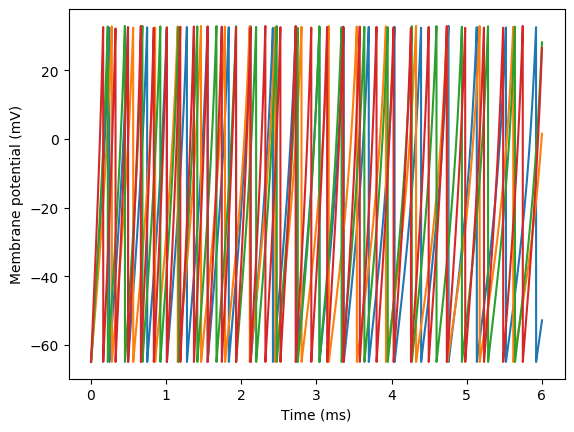

PyObject Text(24.00000000000002, 0.5, 'Membrane potential (mV)')

In [12]:
plt.figure()
plt.plot(collect(1:length(results[1,:])).*dt, results[1:2:end,:]')
plt.xlabel("Time (ms)")
plt.ylabel("Membrane potential (mV)")

## Networks
We can supply the list of layers to construct a network. Then we simulate the network with constant inputs of `[0., -.002]` for 240 seconds with 1 millisecond time steps.

We construct networks by specifying the layers. For now, specifying a list of layers is sufficient to define a feed-forward network. We also need to specify the input dimension of the network, since the inputs don't come from a Layer. In our case, we're driving it with inputs of dimension 2

On the development machine this simulation executes in about 1.6 seconds.

In [15]:
net = Network([L1, L2], 2);

Inputs to a network must be functions of time. If they are constant, we can construct a function which returns a constant input.

The `track_flag` flag indicates whether the `state` of each neuron should be saved at every time step or just the outputs (which tend to be boolean values rather than scalars).

The output matrices are organized such that the row indexes the neuron in the network and the column indexes the time step. Neurons are ordered by layer (first `network.layers[1]`, then `network.layers[2]` and so forth) and within each layer they are orderd according to their entries in `layer.neurons`. So if layer one has 4 neurons and layer two has 6 neurons, rows `1:4` will be from layer one and `5:10` will be from layer two.

In [18]:
dt = 0.001
tf = 240.
t0 = 0.

reset!(net) # Resets each layer, which resets the neurons
input_f(t) = [0., -0.02] 
@time outputs, states = simulate!(net, input_f, dt, tf, track_flag = true);

  2.657599 seconds (16.52 M allocations: 618.123 MiB, 27.63% gc time)


In [19]:
# We can break apart the network to look at what each layer is doing.
# We use i+1 because the first entry is actually the vector we feed in at the first layer; this is an
# implementation detail and shouldn't be necessary for typical use.
for (i,l) in enumerate(net.layers)
    println(i)
    println(net.prev_outputs[i+1])
    println(l.output)
end

1
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
2
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]


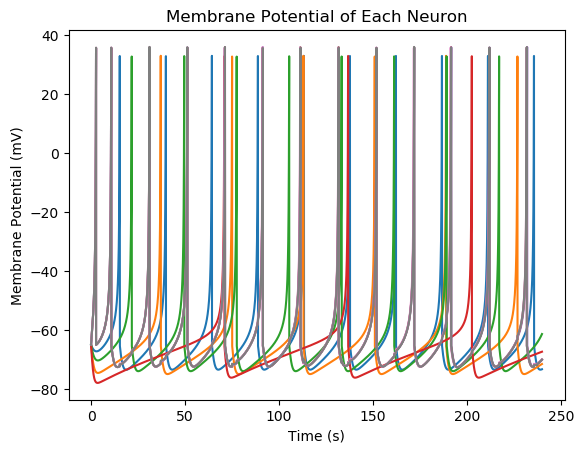

In [21]:
# Plot membrane potentials, skip the recovery variable
plot(t0:dt:tf, transpose(states[1:2:end,:]))
xlabel("Time (s)")
ylabel("Membrane Potential (mV)")
title("Membrane Potential of Each Neuron");

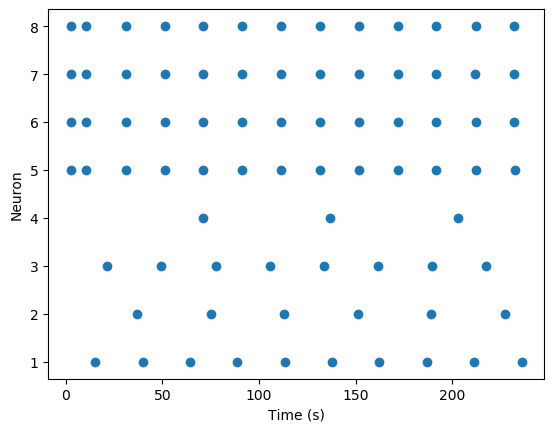

In [22]:
# Spiking event plot for network
xs = []
ys = []
for pt in findall(outputs.>0)
    push!(xs, pt[2]*dt)
    push!(ys, pt[1])
end
scatter(xs, ys)
xlabel("Time (s)")
ylabel("Neuron");

## Arbitrary (recurrent) connections

We also have support for arbitrary topologies. That is to say, `Layer`s can be strung together in a non-feed-forward topology as well. All we have to do is specify which `Layer`s are feeding into the current `Layer` when we construct the `Layer`. 

Note that a `Layer` without connections defaults to feed-forward when placed in a `Network`. In this case, the layer's input weights `W` can just be a matrix. 

If your `Layer` has connections specified, `W` must be declared as a BlockArray.

For this example, we'll construct a network with 3 layers:

 - Layer 1 which takes feedback connections from Layer 3 as well as itself and the network input (denoted by 0)
 - Layer 2 which is feedforward from Layer 1
 - Layer 3 which is feedforward from Layer 2 and skip-connection from Layer 1

In [23]:
using BlockArrays

In [24]:
N_layer = 4
N_in = 8

neurons1 = [Izh() for _ in 1:N_layer]
conns1 = [0, 1, 3]
W10 = randn(N_layer, N_in)
W11 = randn(N_layer, N_layer)
W13 = randn(N_layer, N_layer)

W1 = BlockArray(zeros(N_layer, N_in + 3*N_layer), [N_layer], [N_in, N_layer, N_layer, N_layer]);
setblock!(W1, W10, 1, 1)
setblock!(W1, W11, 1, 2)
setblock!(W1, W13, 1, 4)

layer1 = Layer(neurons1, W1, conns1);

In [25]:
neurons2 = [Izh() for _ in 1:N_layer]
W2 = randn(N_layer, N_layer)
layer2 = Layer(neurons2, W2); # Don't need connections since it's a feed forward layer. Equivalent to conns2 = [1]

In [26]:
neurons3 = [Izh() for _ in 1:N_layer]
conns3 = [1, 2]
W31 = randn(N_layer, N_layer)
W32 = randn(N_layer, N_layer)

W3 = BlockArray(zeros(N_layer, N_in + 3*N_layer), [N_layer], [N_in, N_layer, N_layer, N_layer])
setblock!(W3, W31, 1, 2)
setblock!(W3, W32, 1, 3)

layer3 = Layer(neurons3, W3, conns3);

In [27]:
rnet = Network([layer1, layer2, layer3], N_in);

In [28]:
dt = 0.001
tf = 20.
t0 = 0.

invec = randn(N_in)
input_f(t) = invec

reset!(rnet) # Resets each layer, which resets the neurons
@time outputs, states = simulate!(rnet, input_f, dt, tf, track_flag = true);

  0.315817 seconds (2.24 M allocations: 85.159 MiB)


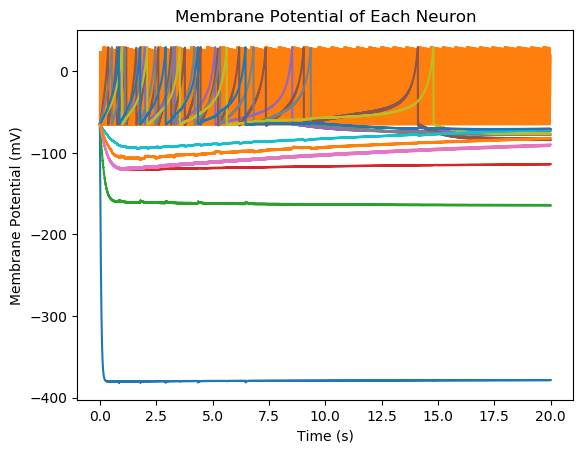

In [29]:
plot(t0:dt:tf, transpose(states[1:2:end,:]))
xlabel("Time (s)")
ylabel("Membrane Potential (mV)")
title("Membrane Potential of Each Neuron");